In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from copy import deepcopy
import pickle as pkl
from tqdm import tqdm
import pandas as pd

from sim_cosmology import p, load_dataloader_and_pretrained_model
p.data_path = '../../src/dsets/cosmology/data'
p.model_path = '../../src/dsets/cosmology/data'
# adaptive-wavelets modules
from losses import get_loss_f
from train import Trainer
from evaluate import Validator
from transform2d import DWT2d
from utils import get_1dfilts, get_2dfilts, get_wavefun
from wave_attributions import Attributer
from visualize import cshow, plot_1dfilts, plot_2dfilts, plot_2dreconstruct, plot_wavefun

# peakcounting
from peak_counting import PeakCount, ModelPred, rmse

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ModuleNotFoundError: No module named 'sim_cosmology'

In [2]:
# get dataloader and model
(train_loader, test_loader), model = load_dataloader_and_pretrained_model(p, img_size=256, shuffle=False)

# Wavelet

In [3]:
kernels = [
           torch.tensor([[-0.1642, -0.3014, -0.1414],
                         [ 0.3502,  0.6425,  0.3014],
                         [-0.1908, -0.3502, -0.1642]]),
           torch.tensor([[-0.1642,  0.3502, -0.1908],
                         [-0.3014,  0.6425, -0.3502],
                         [-0.1414,  0.3014, -0.1642]]),
           torch.tensor([[ 0.1414, -0.3014,  0.1642],
                         [-0.3014,  0.6425, -0.3502],
                         [ 0.1642, -0.3502,  0.1908]])           
          ]
# np.linspace(-0.01,0.02,22)
# kernels = [
#            torch.tensor([[-0.1530, -0.3711, -0.2115],
#                          [ 0.2684,  0.6511,  0.3711],
#                          [-0.1107, -0.2684, -0.1530]]),
#            torch.tensor([[-0.1530,  0.2684, -0.1107],
#                          [-0.3711,  0.6511, -0.2684],
#                          [-0.2115,  0.3711, -0.1530]]),
#            torch.tensor([[ 0.2115, -0.3711,  0.1530],
#                          [-0.3711,  0.6511, -0.2684],
#                          [ 0.1530, -0.2684,  0.1107]])     
#           ]

In [4]:
pcw = PeakCount(peak_counting_method='custom', 
                kernels=kernels)
pcw.peak_list_without_binning(train_loader)

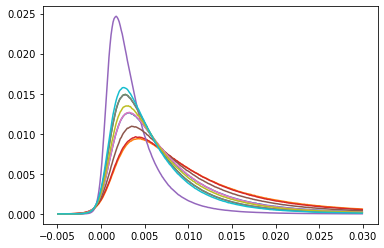

In [5]:
bins = np.linspace(-0.005, 0.03, 300)
for i, k in enumerate(pcw.peak_vals):
    hp = np.histogram(pcw.peak_vals[k], bins=bins)[0]
    xs = 0.5*(bins[:-1] + bins[1:])
    plt.plot(xs, hp/hp.sum())
plt.show()

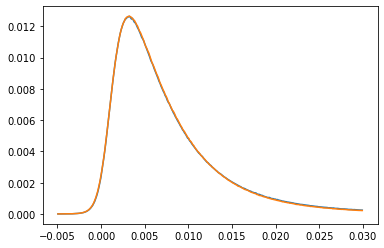

In [9]:
indexes = [0,6]
for idx in indexes:
    xs = 0.5*(bins[:-1] + bins[1:])
    hp = np.histogram(pcw.peak_vals[list(pcw.peak_vals.keys())[idx]], bins=bins)[0]
    plt.plot(xs, hp/hp.sum())
plt.show()

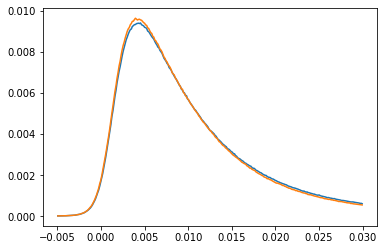

In [10]:
indexes = [1,3]
for idx in indexes:
    xs = 0.5*(bins[:-1] + bins[1:])
    hp = np.histogram(pcw.peak_vals[list(pcw.peak_vals.keys())[idx]], bins=bins)[0]
    plt.plot(xs, hp/hp.sum())
plt.show()

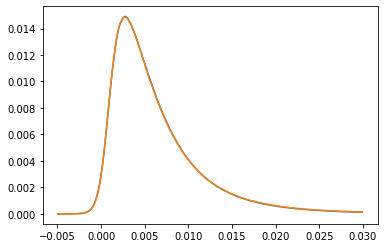

In [11]:
indexes = [2,7]
for idx in indexes:
    xs = 0.5*(bins[:-1] + bins[1:])
    hp = np.histogram(pcw.peak_vals[list(pcw.peak_vals.keys())[idx]], bins=bins)[0]
    plt.plot(xs, hp/hp.sum())
plt.show()

# Laplace

In [23]:
pcl = PeakCount(peak_counting_method='laplace_v1')
pcl.peak_list_without_binning(train_loader)

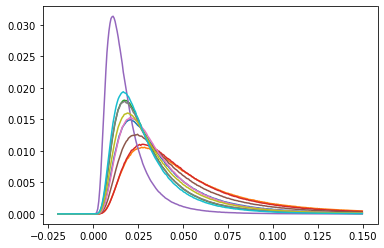

In [26]:
bins = np.linspace(-0.02, 0.15, 300)
for i, k in enumerate(pcl.peak_vals):
    hp = np.histogram(pcl.peak_vals[k], bins=bins)[0]
    xs = 0.5*(bins[:-1] + bins[1:])
    plt.plot(xs, hp/hp.sum())
plt.show()

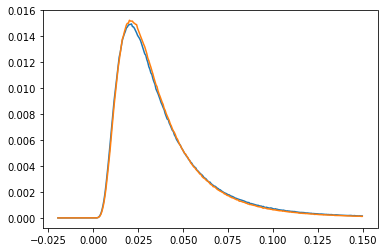

In [27]:
indexes = [0,6]
for idx in indexes:
    xs = 0.5*(bins[:-1] + bins[1:])
    hp = np.histogram(pcl.peak_vals[list(pcl.peak_vals.keys())[idx]], bins=bins)[0]
    plt.plot(xs, hp/hp.sum())
plt.show()

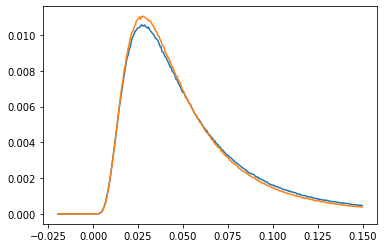

In [28]:
indexes = [1,3]
for idx in indexes:
    xs = 0.5*(bins[:-1] + bins[1:])
    hp = np.histogram(pcl.peak_vals[list(pcl.peak_vals.keys())[idx]], bins=bins)[0]
    plt.plot(xs, hp/hp.sum())
plt.show()

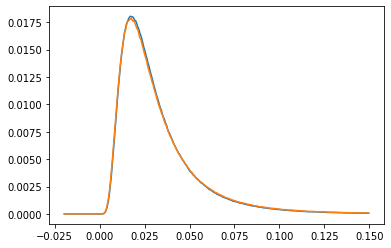

In [29]:
indexes = [2,7]
for idx in indexes:
    xs = 0.5*(bins[:-1] + bins[1:])
    hp = np.histogram(pcl.peak_vals[list(pcl.peak_vals.keys())[idx]], bins=bins)[0]
    plt.plot(xs, hp/hp.sum())
plt.show()

# Peak height

In [39]:
pco = PeakCount(peak_counting_method='original')
pco.peak_list_without_binning(train_loader)

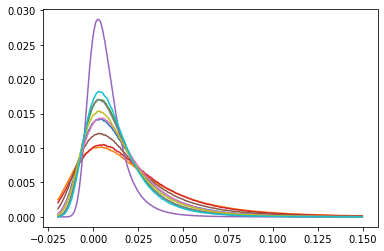

In [40]:
bins = np.linspace(-0.02, 0.15, 300)
for i, k in enumerate(pco.peak_vals):
    hp = np.histogram(pco.peak_vals[k], bins=bins)[0]
    xs = 0.5*(bins[:-1] + bins[1:])
    plt.plot(xs, hp/hp.sum())
plt.show()

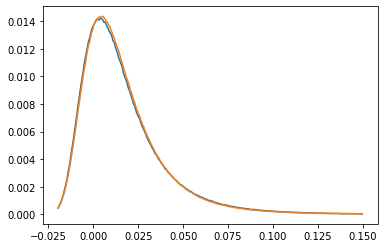

In [41]:
indexes = [0,6]
for idx in indexes:
    xs = 0.5*(bins[:-1] + bins[1:])
    hp = np.histogram(pco.peak_vals[list(pco.peak_vals.keys())[idx]], bins=bins)[0]
    plt.plot(xs, hp/hp.sum())
plt.show()

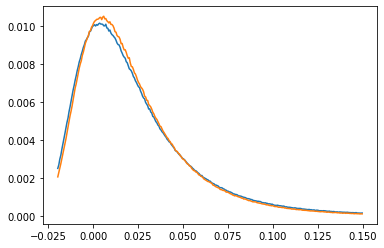

In [42]:
indexes = [1,3]
for idx in indexes:
    xs = 0.5*(bins[:-1] + bins[1:])
    hp = np.histogram(pco.peak_vals[list(pco.peak_vals.keys())[idx]], bins=bins)[0]
    plt.plot(xs, hp/hp.sum())
plt.show()

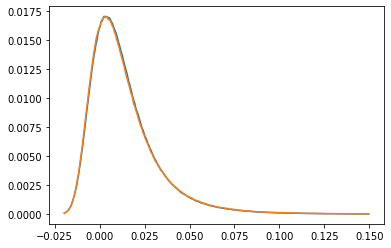

In [43]:
indexes = [2,7]
for idx in indexes:
    xs = 0.5*(bins[:-1] + bins[1:])
    hp = np.histogram(pco.peak_vals[list(pco.peak_vals.keys())[idx]], bins=bins)[0]
    plt.plot(xs, hp/hp.sum())
plt.show()